# Upload the files

In [ ]:
from google.colab import files
files.upload()

# Import the libraries

In [6]:
import re
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import wandb
from wandb.keras import WandbCallback

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, hashing_trick, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Activation, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dropout
from keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import load_data, preprocessing, confusion_matrix_plot, evaluate, get_vocab_size, create_token2id, one_hot_text, get_verdict, get_verdict_with_token2id

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Loading data

In [15]:
df_fake = pd.read_csv('tweet_dataset_18000_fake.csv')
df_true = pd.read_csv('tweet_dataset_18000_true.csv')

df = pd.concat([df_fake.iloc[:9523, [0, 1]], df_true.iloc[:9523, [0, 1]]])
df = df.sample(frac=1)

# Getting the data and Getting the independet and dependent variables

In [16]:
X = df.iloc[:, 0].values
y = df.iloc[:, 1].values

print("X: {}".format(X[0]))
print("y: {}".format(y[0]))

X: A claim that the novel coronavirus was never detected in the major Chinese cities of Beijing and Shanghai has been shared repeatedly on Facebook Twitter and Instagram
y: 0


In [31]:
X_preproc = [preprocessing(i) for i in X]

print('Before: {}'.format(X[0]))
print('After: {}'.format(X_preproc[0]))

Before: A claim that the novel coronavirus was never detected in the major Chinese cities of Beijing and Shanghai has been shared repeatedly on Facebook Twitter and Instagram
After: claim novel coronaviru never detect major chines citi beij shanghai share repeatedli facebook twitter instagram


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_preproc, y, test_size=0.2, random_state=1)

# **Part 1: Traditional machine learning**

In [ ]:
cv = TfidfVectorizer()

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
with open('finalized_countvectorizer.pickle', 'wb') as handle:
    pickle.dump(cv, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model 1. Naive bayes

In [ ]:
naive_bayes = MultinomialNB()

### Grid search

In [ ]:
parameters = [{'alpha': [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5], 'fit_prior': [True, False]}]

grid_search = GridSearchCV(estimator = naive_bayes,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_cv, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 88.46 %
Best Parameters: {'alpha': 0.2, 'fit_prior': True}


### Training the model

In [ ]:
# Initializing the model
naive_bayes = MultinomialNB(alpha=0.2)
# Fitting the data into the model
naive_bayes.fit(X_train_cv, y_train)
# Prediction
prediction = naive_bayes.predict(X_test_cv)

### Evaluating the model

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1907
           1       0.89      0.89      0.89      1903

    accuracy                           0.89      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.89      0.89      0.89      3810

Accuracy score: 0.889763779527559
Precision score: 0.8872062663185378
Recall score: 0.8928008407777194


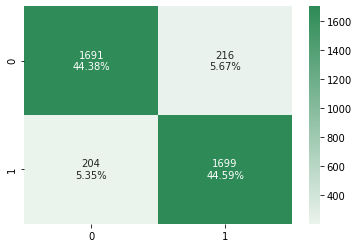

In [ ]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### Save the final model

In [ ]:
pkl_filename = "models/naive_bayes_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(naive_bayes, file)

## Model 2. Logistic Regression

In [ ]:
logistic_regression = LogisticRegression(random_state = 0, max_iter=1000)

### Grid search

In [ ]:
parameters = [{'C': [0, 0.5, 1, 5, 10, 50, 100, 200, 500, 1000], 'penalty': ['l1', 'l2']},
                  {'C': [0, 0.5, 1, 5, 10, 50, 100, 200, 500, 1000], 'penalty': ['l1', 'l2']}]

grid_search = GridSearchCV(estimator = logistic_regression,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_cv, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 88.78 %
Best Parameters: {'C': 1, 'penalty': 'l2'}


### Training the model

In [ ]:
# Initializing the model
logistic_regression = LogisticRegression(C=1, random_state = 0,  max_iter=1000)
# Fitting the data into the model
logistic_regression=logistic_regression.fit(X_train_cv, y_train)
# Prediction
prediction = logistic_regression.predict(X_test_cv)

### Evaluating the model

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1907
           1       0.90      0.89      0.89      1903

    accuracy                           0.89      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.89      0.89      0.89      3810

Accuracy score: 0.8942257217847769
Precision score: 0.8997867803837953
Recall score: 0.8870204939569102


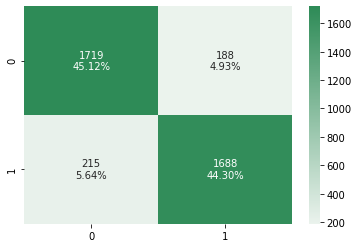

In [ ]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### Save the final model

In [ ]:
pkl_filename = "models/logistic_regression_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logistic_regression, file)

## Model 3. Support vector machine (SVM)

In [ ]:
svm = SVC(random_state = 0)

### Grid search

In [ ]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}]


grid_search = GridSearchCV(estimator = svm,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_cv, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

### Training the model

In [ ]:
# Initializing the model
svm = SVC(kernel = 'linear', C=1, random_state = 0)
# Fitting the data into the model
svm.fit(X_train_cv, y_train)
# Prediction
prediction = svm.predict(X_test_cv)

### Evaluating the model

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1907
           1       0.89      0.89      0.89      1903

    accuracy                           0.89      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.89      0.89      0.89      3810

Accuracy score: 0.8905511811023622
Precision score: 0.892706131078224
Recall score: 0.8875459800315292


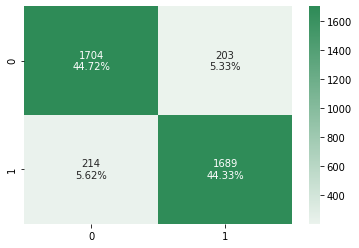

In [ ]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### Save the final model

In [ ]:
pkl_filename = "models/svm_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm, file)

## Model 4. Decision tree

In [ ]:
decision_Tree = DecisionTreeClassifier()

### Grid search

In [ ]:
parameters = [{'criterion':['gini','entropy'], 'max_depth':[None, 1, 5, 10, 20, 50, 90, 100, 150], 'max_features':[None, 'sqrt', 'auto', 'log2'], 'min_samples_split':[1, 2, 5, 10, 20, 40], 'min_samples_leaf':[1, 2, 5, 10, 20,]

grid_search = GridSearchCV(estimator = decision_Tree,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_cv, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 83.89 %
Best Parameters: {'criterion': 'entropy', 'max_depth': 90, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1}


### Training the model

In [ ]:
# Initializing the model
decision_Tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 150)
# Fitting the data into the model
decision_Tree.fit(X_train_cv, y_train)
# Prediction
prediction = decision_Tree.predict(X_test_cv)

### Evaluating the model

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1907
           1       0.86      0.81      0.83      1903

    accuracy                           0.84      3810
   macro avg       0.84      0.84      0.84      3810
weighted avg       0.84      0.84      0.84      3810

Accuracy score: 0.8377952755905512
Precision score: 0.860347728547392
Recall score: 0.8060956384655806


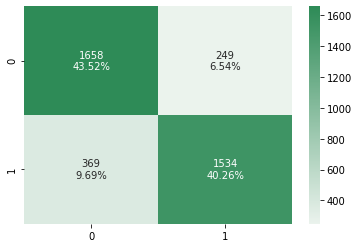

In [ ]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### Save the final model

In [ ]:
pkl_filename = "models/decision_Tree_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(decision_Tree, file)

# **Part 2: Ensemble models**

## Model 5. Random forest

In [ ]:
random_forest = RandomForestClassifier( )

### Grid search

In [ ]:
parameters = [{'n_estimators':[10, 50, 100, 200, 500]}]

grid_search = GridSearchCV(estimator = random_forest,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_cv, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

### Training the model

In [ ]:
# Initializing the model
random_forest = RandomForestClassifier(n_estimators=200, random_state=0)
# Fitting the data into the model
random_forest.fit(X_train_cv, y_train)
# Prediction
prediction = random_forest.predict(X_test_cv)

### Evaluating the model

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1907
           1       0.90      0.87      0.89      1903

    accuracy                           0.89      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.89      0.89      0.89      3810

Accuracy score: 0.8884514435695539
Precision score: 0.8994594594594595
Recall score: 0.8744088281660536


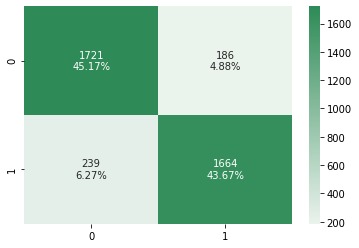

In [ ]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### Save the final model

In [ ]:
pkl_filename = "models/random_forest_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(random_forest, file)

## Model 6. Stacking model

### Training the model

In [ ]:
estimators = [('naive bayes', naive_bayes),
              ('svm', svm),
              ('decision tree', decision_Tree)]

# Initializing the model
Stacking = StackingClassifier(estimators=estimators, final_estimator=logistic_regression)
# Fitting the data into the model
Stacking.fit(X_train_cv, y_train)
# Prediction
prediction = Stacking.predict(X_test_cv)

### Evaluating the model

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1907
           1       0.91      0.90      0.90      1903

    accuracy                           0.90      3810
   macro avg       0.90      0.90      0.90      3810
weighted avg       0.90      0.90      0.90      3810

Accuracy score: 0.9031496062992126
Precision score: 0.9071125265392781
Recall score: 0.8980557015239096


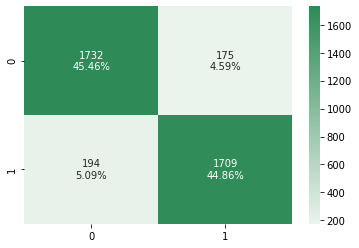

In [ ]:
accuracy = evaluate(y_test, prediction)
confusion_matrix_plot(confusion_matrix(y_test, prediction))

### Save the final model

In [ ]:
pkl_filename = "models/stacking_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(Stacking, file)

# **Part 3. Deep learning**

In [ ]:
all_words = []
for text in X_preproc:
    for i in text_to_word_sequence(text):
        all_words.append(i)
len(all_words)

186737

In [ ]:
with open('words.pickle', 'wb') as handle:
    pickle.dump(all_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('./words.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [20]:
_, max_token = get_vocab_size(X_preproc, [], [])
print('max_token: {}'.format(max_token))

max_token: 19


In [22]:
onehot_train=[hashing_trick(words, round(len(tokenizer)*1.3), hash_function='md5') for words in X_train]
onehot_test=[hashing_trick(words, round(len(tokenizer)*1.3), hash_function='md5') for words in X_test]

train_embedded_docs=pad_sequences(onehot_train,padding='pre',maxlen=max_token)
test_embedded_docs=pad_sequences(onehot_test,padding='pre',maxlen=max_token)

X_train_final=np.array(train_embedded_docs)
X_test_final=np.array(test_embedded_docs)

y_train_final=np.array(y_train)
y_test_final=np.array(y_test)

## Model 7. LSTM

### LSTM - 1 layer - 128 unit + 0.3 Dropout

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 40)            9710360   
_________________________________________________________________
dropout (Dropout)            (None, 19, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               86528     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 9,797,017
Trainable params: 9,797,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
239/239 [==============================] - 48s 186ms/step - loss: 0.5439 - accuracy: 0.7103 - val_loss: 0.2877 - val_accuracy: 0.8840

Epoch 00001: val_accuracy improved from -inf to 0.88399, saving model to ./saved_models/chec

epoch,10
loss,0.07028
accuracy,0.97414
val_loss,0.36158
val_accuracy,0.89475
_runtime,500
_timestamp,1616110408
_step,10
best_val_loss,0.26059
best_epoch,1


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▄▃▃▂▂▂▁▁▁▁
accuracy,▁▅▆▇▇▇█████
val_loss,▂▁▁▂▃▂▅▆▆█▆
val_accuracy,▁█▇▇▇▆▅▇▇▆▆
_runtime,▁▂▃▃▄▅▅▆▇▇█
_timestamp,▁▂▃▃▄▅▅▆▇▇█
_step,▁▂▂▃▄▅▅▆▇▇█


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1907
           1       0.90      0.89      0.90      1903

    accuracy                           0.90      3810
   macro avg       0.90      0.90      0.90      3810
weighted avg       0.90      0.90      0.90      3810

Accuracy score: 0.8979002624671916
Precision score: 0.9018046709129511
Recall score: 0.8928008407777194


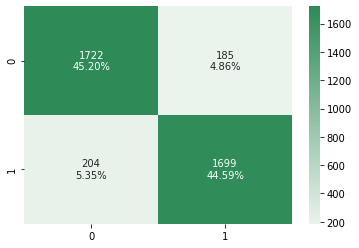

In [ ]:
clear_session()
wandb.init(project='sentence_base', entity='sajadadgar')
config = wandb.config
config.vocab_size = 242759
config.maxlen = max_token
config.embedding_dims = 40
config.hidden_dims = 128
config.epochs = 100

model=Sequential()
model.add(Embedding(config.vocab_size , config.embedding_dims, input_length=config.maxlen))
# model.add(Dropout(0.3))
model.add(LSTM(config.hidden_dims, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

my_callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', mode='min'),
    ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=1, save_best_only=True),
    WandbCallback()
]

model.fit(X_train_final, y_train_final, validation_data=(X_test_final, y_test_final), epochs=config.epochs, batch_size=64, callbacks=my_callbacks)

wandb.finish()
best_model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
prediction = best_model.predict_classes(X_test_final)
accuracy = evaluate(y_test_final, prediction)
confusion_matrix_plot(confusion_matrix(y_test_final, prediction))

#### Save the model

In [ ]:
filename = 'LSTM128_0.3dropout.h5'
best_model.save('models/' + filename)

## Model 8. Bidirectional LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 40)            9710360   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               173056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 9,883,673
Trainable params: 9,883,673
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
239/239 [==============================] - 32s 117ms/step - loss: 0.4979 - accuracy: 0.7300 - val_loss: 0.2746 - val_accuracy: 0.8898

Epoch 00001: val_accuracy improved from -inf to 0.88976, saving model to ./saved_models/chec

INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


Epoch 2/100
239/239 [==============================] - 28s 118ms/step - loss: 0.1912 - accuracy: 0.9292 - val_loss: 0.2779 - val_accuracy: 0.8958

Epoch 00002: val_accuracy improved from 0.88976 to 0.89580, saving model to ./saved_models/checkpoints/best_model


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


Epoch 3/100
239/239 [==============================] - 28s 117ms/step - loss: 0.1508 - accuracy: 0.9457 - val_loss: 0.3148 - val_accuracy: 0.8911

Epoch 00003: val_accuracy did not improve from 0.89580
Epoch 4/100
239/239 [==============================] - 28s 117ms/step - loss: 0.0911 - accuracy: 0.9670 - val_loss: 0.3405 - val_accuracy: 0.8887

Epoch 00004: val_accuracy did not improve from 0.89580
Epoch 5/100
239/239 [==============================] - 28s 117ms/step - loss: 0.0766 - accuracy: 0.9763 - val_loss: 0.4098 - val_accuracy: 0.8853

Epoch 00005: val_accuracy did not improve from 0.89580
Epoch 6/100
239/239 [==============================] - 28s 117ms/step - loss: 0.0525 - accuracy: 0.9830 - val_loss: 0.4202 - val_accuracy: 0.8706

Epoch 00006: val_accuracy did not improve from 0.89580
Epoch 7/100
239/239 [==============================] - 28s 117ms/step - loss: 0.0591 - accuracy: 0.9805 - val_loss: 0.4511 - val_accuracy: 0.8785

Epoch 00007: val_accuracy did not improve fro

epoch,15
loss,0.01684
accuracy,0.99488
val_loss,0.65979
val_accuracy,0.87428
_runtime,488
_timestamp,1616155584
_step,15
best_val_loss,0.27463
best_epoch,0


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇▇█████████
val_loss,▁▁▂▂▃▃▃▄▅▅▅▆▇██▆
val_accuracy,▆█▇▆▅▁▃▅▅▄▃▃▃▃▃▂
_runtime,▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1969
           1       0.90      0.89      0.89      1841

    accuracy                           0.90      3810
   macro avg       0.90      0.90      0.90      3810
weighted avg       0.90      0.90      0.90      3810

Accuracy score: 0.8958005249343832
Precision score: 0.8958333333333334
Recall score: 0.8875611080934275


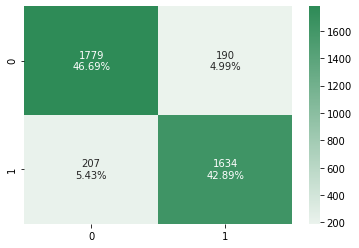

In [38]:
clear_session()
wandb.init(project='sentence_base', entity='sajadadgar')
config = wandb.config
config.vocab_size = 242759
config.maxlen = max_token
config.embedding_dims = 40
config.hidden_dims = 128
config.epochs = 100

model=Sequential()
model.add(Embedding(config.vocab_size,config.embedding_dims,input_length=config.maxlen))
model.add(Bidirectional(LSTM(config.hidden_dims)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

my_callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', mode='min'),
    ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=1, save_best_only=True),
    WandbCallback()
]

model.fit(X_train_final, y_train_final, validation_data=(X_test_final, y_test_final), epochs=config.epochs, batch_size=64, callbacks=my_callbacks)

wandb.finish()
best_model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
prediction = best_model.predict_classes(X_test_final)
accuracy = evaluate(y_test_final, prediction)
confusion_matrix_plot(confusion_matrix(y_test_final, prediction))

### Save the model

In [39]:
filename = 'Bidirectional_LSTM128_0.2dropout.h5'
best_model.save('models/' + filename)

## Model 9. CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 40)            9710360   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 46, 64)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

239/239 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.6941WARNING:tensorflow:Model was constructed with shape (None, 50) for input KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 19).


239/239 [==============================] - 17s 67ms/step - loss: 0.5711 - accuracy: 0.6945 - val_loss: 0.2853 - val_accuracy: 0.8898

Epoch 00001: val_accuracy improved from -inf to 0.88976, saving model to ./saved_models/checkpoints/best_model
INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


Epoch 2/100
239/239 [==============================] - 17s 70ms/step - loss: 0.2114 - accuracy: 0.9213 - val_loss: 0.2663 - val_accuracy: 0.8948

Epoch 00002: val_accuracy improved from 0.88976 to 0.89475, saving model to ./saved_models/checkpoints/best_model
INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


Epoch 3/100
239/239 [==============================] - 15s 64ms/step - loss: 0.1405 - accuracy: 0.9542 - val_loss: 0.2829 - val_accuracy: 0.8906

Epoch 00003: val_accuracy did not improve from 0.89475
Epoch 4/100
239/239 [==============================] - 15s 61ms/step - loss: 0.0804 - accuracy: 0.9738 - val_loss: 0.3144 - val_accuracy: 0.8898

Epoch 00004: val_accuracy did not improve from 0.89475
Epoch 5/100
239/239 [==============================] - 15s 61ms/step - loss: 0.0491 - accuracy: 0.9859 - val_loss: 0.3590 - val_accuracy: 0.8885

Epoch 00005: val_accuracy did not improve from 0.89475
Epoch 6/100
239/239 [==============================] - 15s 61ms/step - loss: 0.0292 - accuracy: 0.9914 - val_loss: 0.4088 - val_accuracy: 0.8871

Epoch 00006: val_accuracy did not improve from 0.89475
Epoch 7/100
239/239 [==============================] - 15s 61ms/step - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.4577 - val_accuracy: 0.8861

Epoch 00007: val_accuracy did not improve from 0.8

epoch,22
loss,0.00492
accuracy,0.99829
val_loss,0.90263
val_accuracy,0.88373
_runtime,352
_timestamp,1616156755
_step,22
best_val_loss,0.26632
best_epoch,1


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇██████████████████
val_loss,▁▁▁▂▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█
val_accuracy,▅█▅▅▄▃▃▃▅▃▃▃▁▃▂▁▁▂▂▂▂▂▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1969
           1       0.89      0.89      0.89      1841

    accuracy                           0.89      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.89      0.89      0.89      3810

Accuracy score: 0.894750656167979
Precision score: 0.8887688984881209
Recall score: 0.8940793047256925


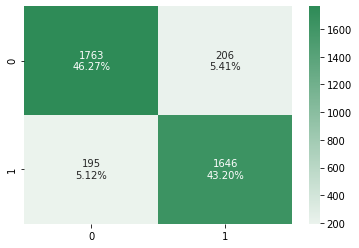

In [43]:
clear_session()
wandb.init(project='sentence_base', entity='sajadadgar')
config = wandb.config
config.vocab_size = 242759
config.maxlen = 50
config.embedding_dims = 40
config.hidden_dims = 64
config.epochs = 100

model = Sequential()
model.add(Embedding(config.vocab_size,config.embedding_dims,input_length=config.maxlen))
model.add(Conv1D(config.hidden_dims, 5, activation='relu'))
# model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


my_callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', mode='min'),
    ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=1, save_best_only=True),
    WandbCallback()
]

model.fit(X_train_final, y_train_final, validation_data=(X_test_final,y_test_final), epochs=config.epochs, batch_size=64, callbacks=my_callbacks)

wandb.finish()
best_model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
prediction = best_model.predict_classes(X_test_final)
accuracy = evaluate(y_test_final, prediction)
confusion_matrix_plot(confusion_matrix(y_test_final, prediction))

### Save the model

In [44]:
filename = 'CNN64_0.2dropout.h5'
best_model.save('models/' + filename)

## Model 10. CNN + LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 40)            9710360   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           25728     
_________________________________________________________________
dropout (Dropout)            (None, 46, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

239/239 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.7168WARNING:tensorflow:Model was constructed with shape (None, 50) for input KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 19).


239/239 [==============================] - 20s 73ms/step - loss: 0.5207 - accuracy: 0.7172 - val_loss: 0.3085 - val_accuracy: 0.8701

Epoch 00001: val_accuracy improved from -inf to 0.87008, saving model to ./saved_models/checkpoints/best_model


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


Epoch 2/100
239/239 [==============================] - 22s 93ms/step - loss: 0.2199 - accuracy: 0.9136 - val_loss: 0.3057 - val_accuracy: 0.8769

Epoch 00002: val_accuracy improved from 0.87008 to 0.87690, saving model to ./saved_models/checkpoints/best_model


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoints/best_model/assets


Epoch 3/100
239/239 [==============================] - 18s 74ms/step - loss: 0.1564 - accuracy: 0.9403 - val_loss: 0.3360 - val_accuracy: 0.8706

Epoch 00003: val_accuracy did not improve from 0.87690
Epoch 4/100
239/239 [==============================] - 17s 71ms/step - loss: 0.1079 - accuracy: 0.9607 - val_loss: 0.3710 - val_accuracy: 0.8748

Epoch 00004: val_accuracy did not improve from 0.87690
Epoch 5/100
239/239 [==============================] - 17s 72ms/step - loss: 0.0774 - accuracy: 0.9727 - val_loss: 0.3939 - val_accuracy: 0.8651

Epoch 00005: val_accuracy did not improve from 0.87690
Epoch 6/100
239/239 [==============================] - 17s 71ms/step - loss: 0.0632 - accuracy: 0.9759 - val_loss: 0.4810 - val_accuracy: 0.8633

Epoch 00006: val_accuracy did not improve from 0.87690
Epoch 7/100
239/239 [==============================] - 17s 72ms/step - loss: 0.0381 - accuracy: 0.9846 - val_loss: 0.5505 - val_accuracy: 0.8698

Epoch 00007: val_accuracy did not improve from 0.8

epoch,33
loss,0.00706
accuracy,0.99724
val_loss,1.13591
val_accuracy,0.87165
_runtime,604
_timestamp,1616157507
_step,33
best_val_loss,0.30572
best_epoch,1


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▆▇▇▇███████████████████████████
val_loss,▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▅▆▇▆▇▇▇▆▇▇▇█▇████▇▇
val_accuracy,▆█▆▇▄▃▅▆▅▆▅▄▄▂▅▃▃▂▃▄▄▄▅▁▅▄▃▄▃▄▅▃▄▆
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1969
           1       0.87      0.88      0.87      1841

    accuracy                           0.88      3810
   macro avg       0.88      0.88      0.88      3810
weighted avg       0.88      0.88      0.88      3810

Accuracy score: 0.8769028871391076
Precision score: 0.8688172043010752
Recall score: 0.8777838131450298


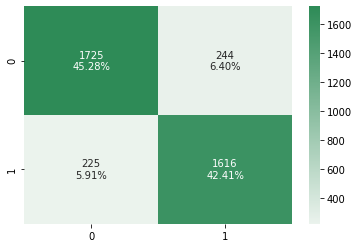

In [45]:
clear_session()
wandb.init(project='sentence_base', entity='sajadadgar')
config = wandb.config
config.vocab_size = 242759
config.maxlen = 50
config.embedding_dims = 40
config.hidden_dims = 64
config.epochs = 100

model = Sequential()
model.add(Embedding(config.vocab_size,config.embedding_dims,input_length=config.maxlen))
model.add(Conv1D(128, 5, activation='relu'))
# model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(config.hidden_dims))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())


my_callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', mode='min'),
    ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=1, save_best_only=True),
    WandbCallback()
]

model.fit(X_train_final, y_train_final, validation_data=(X_test_final,y_test_final), epochs=config.epochs, batch_size=64, callbacks=my_callbacks)

wandb.finish()
best_model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
prediction = best_model.predict_classes(X_test_final)
accuracy = evaluate(y_test_final, prediction)
confusion_matrix_plot(confusion_matrix(y_test_final, prediction))

### Save the model

In [46]:
filename = 'CNN128_LSTM128_0.2dropout.h5'
best_model.save('models/' + filename)